In [104]:
# install packages and libraries

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

In [105]:
# Read the data
bbp = pd.read_csv("/Users/andriy/Desktop/GSB544_ML/Week_7/Lab6/Hitters.csv")

bbp.head()


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


Categorical variables for dummification:
'League'
'Division'
'NewLeague'

In [106]:
check_cols = bbp.isna().sum()

NA values appear in Salary column, which is a target variable. Therefore, dropna should fix the issue.

In [319]:
# Drop other NAs
bbp = bbp.dropna()

In [6]:
len(bbp) 
# 263 rows without na 

263

In [108]:
bbp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64(1), 

# Part I: Different Model Specs

In [109]:
# Select variables
X = bbp.drop(["Salary"], axis = 1)
y = bbp["Salary"]

## A. Regression without regularization


In [207]:
# 1. Set up the pipeline

ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"), ## use drop="first" to holdout one of the dummy variable columns as reference
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

In [111]:
X_head = ct.fit_transform(X).head()

In [112]:
X_head

,dummify__League_N,dummify__Division_W,dummify__NewLeague_N,standardize__AtBat,standardize__Hits,standardize__HmRun,standardize__Runs,standardize__RBI,standardize__Walks,standardize__Years,standardize__CAtBat,standardize__CHits,standardize__CHmRun,standardize__CRuns,standardize__CRBI,standardize__CWalks,standardize__PutOuts,standardize__Assists,standardize__Errors
1,1.0,1.0,1.0,-0.602900,-0.595675,-0.528551,-1.206112,-0.522063,-0.097527,1.397893,0.346791,0.174373,-0.002920,-0.121671,0.258966,0.435334,1.221499,-0.523191,0.213352
2,0.0,1.0,0.0,0.512542,0.492260,0.729966,0.441515,0.794060,1.609373,-0.901200,-0.452865,-0.409892,-0.076054,-0.415105,-0.199590,0.010373,2.109109,-0.253863,0.819964
3,1.0,0.0,1.0,0.628167,0.736490,0.958788,0.402286,1.026317,-0.189792,0.770868,1.301558,1.318174,1.898565,1.412051,1.572666,0.355654,-0.324661,-0.744179,-0.848219
4,1.0,0.0,1.0,-0.562092,-0.462459,-0.185319,-0.617673,-0.367225,-0.512719,-1.110209,-0.990935,-0.960153,-0.697693,-0.947521,-0.881228,-0.862315,1.840678,-0.543909,-0.696566
5,0.0,1.0,0.0,1.294712,1.358167,-0.871783,0.755349,-0.018840,-0.282057,0.770868,0.766993,0.634985,-0.612370,0.422846,0.017294,-0.251434,-0.031177,2.087225,2.488147


In [113]:
# 2. fit the pipeline on whole dataset

lr_fitted = lr_pipeline_1.fit(X, y)

lr_fitted.named_steps['linear_regression'].coef_

array([  62.59942304, -116.84924564,  -24.76232511, -291.0945557 ,  337.83047948,   37.85383676,  -60.57247861,  -26.99498379,  135.07389695,  -16.69335888, -391.03865466,   86.68761664,  -14.18172332,  480.74713477,  260.68988581, -213.89225864,   78.76129639,   53.73248973,
        -22.16086217])

In [114]:
# create dataframe with betas and header # assisted by ChatGPT

columns_to_extract = X_head.columns.tolist()  # list of columns from 'X head'
beta_headers = [col for col in columns_to_extract if col != X_head.index.name] # Ensures index column is skipped

In [105]:
# len(beta_headers)

In [43]:
# beta_headers

In [35]:
# len(lr_fitted.named_steps['linear_regression'].coef_)

In [115]:
# Merging the lists into a DataFrame
coef_df_LR = pd.DataFrame({'Variable': beta_headers, 'Coef_LR': lr_fitted.named_steps['linear_regression'].coef_})

In [116]:
coef_df_LR.sort_values(by=['Coef_LR'], ascending=False)

,Variable,Coef_LR
13,standardize__CRuns,480.747135
4,standardize__Hits,337.830479
14,standardize__CRBI,260.689886
8,standardize__Walks,135.073897
11,standardize__CHits,86.687617
16,standardize__PutOuts,78.761296
0,dummify__League_N,62.599423
17,standardize__Assists,53.732490
5,standardize__HmRun,37.853837
12,standardize__CHmRun,-14.181723


Based on this model output, the following are the top 5 predictor variables with

The highest betas:
CRuns, Hits, CRBI, Walks, CHits

The lowest betas:
CAtBat, AtBat, CWalks, Division_W, Runs

In [117]:
# 3. use cross-validation to estimate MSE

lr_cv_scores = cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'r2')
lr_mse_scores = cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = ('neg_mean_squared_error'))*(-1)
print ("OLR CV mean R-squared score:", np.mean(lr_cv_scores))
print ("OLR CV mean MSE score:", np.mean(lr_mse_scores))

OLR CV mean R-squared score: 0.3434950217881679
OLR CV mean MSE score: 121136.31031816879
OLR CV mean R-squared score: 0.3434950217881679
OLR CV mean MSE score: 121136.31031816879


MSE score based on cross-validation (5-fold): 121136.3103181687. R-squared is 0.343.

## B. Ridge regression

In [118]:
# create a pipeline for Ridge regression and tune lambda with cross-validation

ridge_pipeline_1 = Pipeline(
    [("preprocessing", ct),
    ("ridge_regression", Ridge())]
).set_output(transform="pandas")

degrees = {'ridge_regression__alpha': [0.01, 0.1, 10, 12, 15, 20, 30, 40, 80, 200, 300, 400, 500]}

gscv = GridSearchCV(ridge_pipeline_1, degrees, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_

{'mean_fit_time': array([0.00834441, 0.0030056 , 0.00309525, 0.00323486, 0.00293021, 0.00274782, 0.00296707, 0.00286412, 0.00290828, 0.00282345, 0.00282693, 0.00281458, 0.00302062]),
 'std_fit_time': array([7.95565317e-03, 4.24135183e-04, 3.98395679e-04, 6.89070793e-04, 3.18962409e-04, 8.79299098e-05, 3.32705910e-04, 3.13483642e-04, 2.82986499e-04, 2.81967871e-04, 3.05691150e-04, 1.44426364e-04, 4.56709881e-04]),
 'mean_score_time': array([0.00313258, 0.00161958, 0.00172849, 0.00192728, 0.0015851 , 0.00166121, 0.00168023, 0.0015429 , 0.0017271 , 0.00156302, 0.00170794, 0.00171723, 0.00162501]),
 'std_score_time': array([1.11543644e-03, 5.00345119e-05, 2.46823893e-04, 3.54421695e-04, 9.00076840e-05, 2.48021594e-04, 2.59374808e-04, 2.13608145e-05, 2.09414752e-04, 6.22398356e-05, 2.55704547e-04, 2.94960636e-04, 1.26393998e-04]),
 'param_ridge_regression__alpha': masked_array(data=[0.01, 0.1, 10.0, 12.0, 15.0, 20.0, 30.0, 40.0, 80.0, 200.0, 300.0, 400.0, 500.0],
              mask=[False, 

In [119]:
ridge_scores_1_df = pd.DataFrame(data = {"degrees": [0.01, 0.1, 10, 12, 15, 20, 30, 40, 80, 200, 300, 400, 500], "scores_Ridge": gscv_fitted.cv_results_['mean_test_score']})

In [120]:
ridge_scores_1_df.sort_values(by=['scores_Ridge'], ascending=False)

,degrees,scores_Ridge
9,200.00,0.384298
8,80.00,0.383518
10,300.00,0.380973
7,40.00,0.380005
6,30.00,0.378256
11,400.00,0.375824
5,20.00,0.375648
4,15.00,0.373739
3,12.00,0.372235
2,10.00,0.370992


Based on different degrees in tunning, lamda = 200 in Ridge regression yields the highest R-sqaured score for this model.

In [121]:
# fit the pipeline with the highest lambda (200) on full dataset
ridge_pipeline_1.set_params(ridge_regression__alpha=200)
ridge_fitted = ridge_pipeline_1.fit(X, y)
ridge_fitted.named_steps['ridge_regression'].coef_

array([  9.93667803, -33.68964736,   6.45216506,  11.41326592,  38.26237745,   4.80170835,  27.43018771,  23.25680815,  35.2579734 ,   7.15940027,  25.82303926,  36.62687579,  32.55984813,  37.60037546,  38.34652764,  15.13804223,  46.00941963,   4.29511667,  -8.45517812])

In [119]:
# len(ridge_fitted.named_steps['ridge_regression'].coef_)

In [122]:
# turn coefficients to a dataframe

coef_df_Ridge = pd.DataFrame({'Variable': beta_headers, 'Coef_Ridge': ridge_fitted.named_steps['ridge_regression'].coef_})
coef_df_Ridge.sort_values(by=['Coef_Ridge'], ascending=False)

,Variable,Coef_Ridge
16,standardize__PutOuts,46.009420
14,standardize__CRBI,38.346528
4,standardize__Hits,38.262377
13,standardize__CRuns,37.600375
11,standardize__CHits,36.626876
8,standardize__Walks,35.257973
12,standardize__CHmRun,32.559848
6,standardize__Runs,27.430188
10,standardize__CAtBat,25.823039
7,standardize__RBI,23.256808


According to this model output for Ridge regression with tuned 'lamda'=200, the following are the top 5 predictor variables with

The highest betas:
PutOuts, CRBI, Hits, CRuns

The lowest betas:
Division_W, Errors, Assists, HmRun, NewLeague_N

The range of coefficients values in Ridge are more narrow than in LR, also less negative coefficients. Surprisingly HmRun has 4th lowest coefficient in Ridge, while its 9th highest in LR (which makes a bit more sense intuitively).

In [123]:
# MSE

y_pred = ridge_fitted.predict(X)
MSE_Ridge_1 = mean_squared_error(y, y_pred)
MSE_Ridge_1

np.float64(110391.53707120112)

In [124]:
# R-squared
Rsq_Ridge_1 = r2_score(y, y_pred)
Rsq_Ridge_1

0.4554865463570007

The MSE of this Ridge model prediction is 110391.53 and R-squared is 0.455 on full data or 0.384 when tuning for best lambda.

## C. Lasso regression

In [125]:
# create a pipeline for Ridge regression and tune lambda with cross-validation

lasso_pipeline_1 = Pipeline(
    [("preprocessing", ct),
    ("lasso_regression", Lasso())]
).set_output(transform="pandas")

degrees = {'lasso_regression__alpha': [0.01, 0.1, 10, 12, 15, 20, 30, 40, 80, 200, 300, 400, 500]}

gscv = GridSearchCV(lasso_pipeline_1, degrees, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.594e+06, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.059e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

{'mean_fit_time': array([0.01012149, 0.00560174, 0.00325847, 0.00310278, 0.00293126, 0.00290689, 0.00318189, 0.00305882, 0.00310788, 0.00271688, 0.00286493, 0.0026866 , 0.00281267]),
 'std_fit_time': array([5.86690072e-03, 2.03020811e-04, 2.75541663e-04, 9.71166410e-05, 1.00658686e-04, 7.11503678e-05, 2.68668581e-04, 3.13684511e-04, 5.55381873e-04, 6.54448533e-05, 1.17354904e-04, 3.76760502e-05, 2.80186990e-04]),
 'mean_score_time': array([0.0025115 , 0.00170979, 0.00171971, 0.00156975, 0.00152731, 0.00155063, 0.0016427 , 0.00169601, 0.00159488, 0.00154967, 0.00162129, 0.00153708, 0.00158391]),
 'std_score_time': array([7.47412806e-04, 1.31769926e-04, 1.73328897e-04, 2.19531602e-05, 7.83813544e-06, 3.35221609e-05, 1.39688223e-04, 1.72964396e-04, 1.34730978e-04, 3.78169446e-05, 1.50341727e-04, 1.21831661e-05, 6.84905829e-05]),
 'param_lasso_regression__alpha': masked_array(data=[0.01, 0.1, 10.0, 12.0, 15.0, 20.0, 30.0, 40.0, 80.0, 200.0, 300.0, 400.0, 500.0],
              mask=[False, 

In [126]:
lasso_scores_1_df = pd.DataFrame(data = {"degrees": [0.01, 0.1, 10, 12, 15, 20, 30, 40, 80, 200, 300, 400, 500], "scores_Lasso": gscv_fitted.cv_results_['mean_test_score']})

In [127]:
lasso_scores_1_df.sort_values(by=['scores_Lasso'], ascending=False)

,degrees,scores_Lasso
5,20.00,0.377168
4,15.00,0.376381
3,12.00,0.374292
6,30.00,0.369527
2,10.00,0.369523
7,40.00,0.366333
1,0.10,0.346041
0,0.01,0.344394
8,80.00,0.327790
9,200.00,0.082359


Based on different degrees in tunning, lamda = 20 in Lasso regression yields the highest R-sqaured score for this model.

In [129]:
# fit the pipeline with the highest lambda (200) on full dataset
lasso_pipeline_1.set_params(lasso_regression__alpha=20)
lasso_fitted = lasso_pipeline_1.fit(X, y)
lasso_fitted.named_steps['lasso_regression'].coef_

array([  0.        , -57.18082557,   0.        ,   0.        ,  84.02579041,   0.        ,   0.        ,   0.        ,  47.90533684,  -0.        ,   0.        ,   0.        ,   0.        ,  71.2459134 , 128.20172096,   0.        ,  59.49673719,  -0.        ,  -0.        ])

In [160]:
# len(lasso_fitted.named_steps['lasso_regression'].coef_)

In [130]:
# turn coefficients to a dataframe

coef_df_Lasso = pd.DataFrame({'Variable': beta_headers, 'Coef_Lasso': lasso_fitted.named_steps['lasso_regression'].coef_})
coef_df_Lasso.sort_values(by=['Coef_Lasso'], ascending=False)

,Variable,Coef_Lasso
14,standardize__CRBI,128.201721
4,standardize__Hits,84.025790
13,standardize__CRuns,71.245913
16,standardize__PutOuts,59.496737
8,standardize__Walks,47.905337
0,dummify__League_N,0.000000
11,standardize__CHits,0.000000
17,standardize__Assists,-0.000000
15,standardize__CWalks,0.000000
12,standardize__CHmRun,0.000000


According to this model output for Lasso regression with 'lamda'=20, the following are the top 5 predictor variables with

The highest betas:
CRBI (Number of runs batted in during his career), Hits, CRuns, PutOuts, Walks. From an intuitive perspective it makes sense that this variables have some of the highest betas, however it may be surprising to see that some of the variables had 0 coefficients eg. HmRun, CHmRun or Years.

The lowest betas:
Division_W, all variables betas are 0.

The range of coefficients values in this Lasso model are more narrow than in LR but wider than in Ridge, also less majority of coefficients are 0.

In [131]:
# MSE

y_pred = lasso_fitted.predict(X)
MSE_Lasso_1 = mean_squared_error(y, y_pred)
MSE_Lasso_1

np.float64(106297.82456925086)

In [132]:
# R-squared
Rsq_Lasso_1 = r2_score(y, y_pred)
Rsq_Lasso_1

0.4756790501647946

The MSE of this Lasso model prediction is 106297. This is by -3.8% lower than the MSE of Ridge regression model. The R-squared is 0.475 on full data or 0.377 when tuning for best lambda.

## D. Elastic Net

In [133]:
# create a pipeline for Ridge regression and tune lambda with cross-validation

elasticnet_pipeline_1 = Pipeline(
    [("preprocessing", ct),
    ("elasticnet_regression", ElasticNet())]
)

degrees = {
    'elasticnet_regression__alpha': [0.01, 0.02, 0.1, 10, 12, 15, 20, 30, 40, 80, 200],
    'elasticnet_regression__l1_ratio': [0.01, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 0.8]
}

gscv = GridSearchCV(elasticnet_pipeline_1, degrees, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.565e+03, tolerance: 4.137e+03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.307e+05, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

{'mean_fit_time': array([0.00991287, 0.0057344 , 0.00535278, 0.00522337, 0.00516706, 0.00523081, 0.00554261, 0.0056324 , 0.00448785, 0.00449305, 0.00486336, 0.0050982 , 0.00488691, 0.00446677, 0.00520358, 0.00555654, 0.0034862 , 0.00321651, 0.0031167 , 0.00344319, 0.00344214, 0.00342927, 0.00354147,
        0.00363955, 0.00279036, 0.00272121, 0.00277104, 0.00266042, 0.0026969 , 0.00274949, 0.00274878, 0.00280576, 0.00274053, 0.0027936 , 0.00295835, 0.00295343, 0.00324574, 0.00326285, 0.00348587, 0.00328579, 0.00349398, 0.00331993, 0.00361228, 0.00352674, 0.00339293, 0.00302677,
        0.00278106, 0.00320482, 0.00282187, 0.00278101, 0.00271683, 0.00273356, 0.00279751, 0.00273623, 0.00270057, 0.00272741, 0.00269399, 0.00279474, 0.00273323, 0.00271244, 0.00267038, 0.00288568, 0.00268502, 0.00274615, 0.00266905, 0.00271645, 0.00280018, 0.00272245, 0.00266261,
        0.00269179, 0.00275445, 0.00284491, 0.00268373, 0.00274129, 0.00284958, 0.00272403, 0.0027205 , 0.00270386, 0.00274782, 0.0

In [134]:
alphas = gscv_fitted.cv_results_['param_elasticnet_regression__alpha'].data
l1_ratios = gscv_fitted.cv_results_['param_elasticnet_regression__l1_ratio'].data
mean_scores = gscv_fitted.cv_results_['mean_test_score']

elasticnet_scores_df = pd.DataFrame({
    "degrees_lambda": alphas, 
    "degrees_alpha": l1_ratios,
    "scores_ElasticNet": mean_scores
    })

elasticnet_scores_df.sort_values(by='scores_ElasticNet', ascending=False).head()

,degrees_lambda,degrees_alpha,scores_ElasticNet
16,0.1,0.01,0.375926
17,0.1,0.10,0.375303
18,0.1,0.15,0.374927
19,0.1,0.20,0.374529
20,0.1,0.30,0.373650


Based on different degrees in tunning, lambda = 0.1 and alpha = 0.01 in Elastic Net regression yields the highest R-sqaured score for this model.

In [135]:
# fit the pipeline with the highest hyperparameters on full dataset
elasticnet_pipeline_1.set_params(elasticnet_regression__alpha=0.1)
elasticnet_pipeline_1.set_params(elasticnet_regression__l1_ratio=0.01)
elasticnet_fitted = elasticnet_pipeline_1.fit(X, y)
elasticnet_fitted.named_steps['elasticnet_regression'].coef_

array([ 28.57370253, -93.52899097,   2.9763194 , -61.58449938,  93.77037343, -13.13940914,  30.70637806,  22.60247941,  60.69400055, -31.65717284,  10.6266831 ,  70.76094692,  51.90633684,  76.34149071,  71.95240841, -42.60901653,  70.99938787,  18.88668801, -21.80227611])

In [168]:
# len(elasticnet_fitted.named_steps['elasticnet_regression'].coef_)

In [136]:
# turn coefficients to a dataframe

coef_df_Elasticnet = pd.DataFrame({'Variable': beta_headers, 'Coef_ElasticNet': elasticnet_fitted.named_steps['elasticnet_regression'].coef_})
coef_df_Elasticnet.sort_values(by=['Coef_ElasticNet'], ascending=False)

,Variable,Coef_ElasticNet
4,standardize__Hits,93.770373
13,standardize__CRuns,76.341491
14,standardize__CRBI,71.952408
16,standardize__PutOuts,70.999388
11,standardize__CHits,70.760947
8,standardize__Walks,60.694001
12,standardize__CHmRun,51.906337
6,standardize__Runs,30.706378
0,dummify__League_N,28.573703
7,standardize__RBI,22.602479


According to this model output for Elastic Net regression with 'lambda' = 0.1 and 'alpha' = 0.01, the following are the top 5 predictor variables with

The highest betas:
Hits, CRuns, CRBIm PutOuts, CHits. From an intuitive perspective it also makes sense that this variables have some of the highest betas.

The lowest betas:
Division_W, AtBat, CWalks, Years, Errors.
It is surprising to see HmRun with 6th lowest and negative coef.

The range of coefficients values in this Elastic Net model are more equally ranged around 0 with highest and lowest Betas of equivalent values on the opposite sides.

In [137]:
# MSE

y_pred = elasticnet_fitted.predict(X)
MSE_ElasticNet_1 = mean_squared_error(y, y_pred)
MSE_ElasticNet_1

np.float64(100526.0956012104)

In [138]:
# R-squared
Rsq_ElNet_1 = r2_score(y, y_pred)
Rsq_ElNet_1

0.5041484795908202

The MSE of this Elastic Net model prediction is 100526. This is by -5.7% lower than the MSE of Lasso regression model. The R-squared is 0.50 on full data or 0.375 when tunning for best lambda and alpha.

# Part II. Variable Selection

Based on the above results, decide on:

 - Which numeric variable is most important: 'Hits'
   ['standardize__Hits']

 - Which five numeric variables are most important: 'Hits', 'CRuns', 'CRBI', 'PutOuts', 'CHits' 
   ['standardize__Hits', 'standardize__CRuns', 'standardize__CRBI', 'standardize__PutOuts', 'standardize__CHits']

 - Which categorical variable is most important: 'Division' 
   ['dummify__Division_W']

# Feature set 1:  'X' = "Hits"

In [139]:
# Feature set 1:

X = bbp[["Hits"]]
y = bbp["Salary"]

In [140]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Hits    263 non-null    int64
dtypes: int64(1)
memory usage: 4.1 KB
<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Hits    263 non-null    int64
dtypes: int64(1)
memory usage: 4.1 KB


In [141]:
# Check 'X' variable names after transformation in ct # Assisted by ChatGPT

# Fit and transform the data
X_transformed = ct.fit_transform(X)

# Convert the result to a DataFrame
X_tr = pd.DataFrame(X_transformed, columns=ct.get_feature_names_out())

# Display the first rows
X_tr.head()

,standardize__Hits
1,-0.595675
2,0.492260
3,0.736490
4,-0.462459
5,1.358167


## OLR FS_1: "Hits"

In [142]:
#  fitting

lr_fitted_2 = lr_pipeline_1.fit(X, y)

lr_fitted_2.named_steps['linear_regression'].coef_


array([197.51778566])

In [143]:
# create dataframe with betas and header

columns_to_extract = X_tr.columns.tolist()  # list of columns from 'X tr'
beta_headers = [col for col in columns_to_extract if col != X_tr.index.name] # Ensures index column is skipped

In [144]:
# Merging the lists into a DataFrame
coef_df_LR_2 = pd.DataFrame({'Variable': beta_headers, 'Coef_LR': lr_fitted_2.named_steps['linear_regression'].coef_})

In [145]:
coef_df_LR_2.sort_values(by=['Coef_LR'], ascending=False)

,Variable,Coef_LR
0,standardize__Hits,197.517786


In [146]:
# use cross-validation to estimate MSE

lr_2_cv_scores = cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'r2')
lr_2_mse_scores = cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = ('neg_mean_squared_error'))*(-1)
print ("OLR CV mean R-squared score:", np.mean(lr_2_cv_scores))
print ("OLR CV mean MSE score:", np.mean(lr_2_mse_scores))

OLR CV mean R-squared score: 0.12221278728446772
OLR CV mean MSE score: 173088.97286444032
OLR CV mean R-squared score: 0.12221278728446772
OLR CV mean MSE score: 173088.97286444032


## Ridge FS_1: "Hits"

In [147]:
# Ridge regression and tune lambda with cross-validation

degrees = {'ridge_regression__alpha': [0.01, 0.1, 10, 12, 15, 20, 30, 40, 80, 200, 300, 400, 500]} # coping degrees parameter from the original pipline setup

gscv = GridSearchCV(ridge_pipeline_1, degrees, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_

{'mean_fit_time': array([0.00462742, 0.00228448, 0.0019258 , 0.00175433, 0.00178242, 0.00175853, 0.00188513, 0.00166659, 0.00158458, 0.00167007, 0.00163894, 0.00171499, 0.00171223]),
 'std_fit_time': array([2.22756891e-03, 1.37570074e-04, 1.12155972e-04, 1.01587737e-04, 1.06573585e-04, 1.88654787e-04, 1.73646155e-04, 6.15429246e-05, 6.67807674e-05, 1.43278212e-04, 5.88470763e-05, 2.15583105e-04, 1.67285295e-04]),
 'mean_score_time': array([0.00236158, 0.00129037, 0.00104022, 0.00098591, 0.00099473, 0.00096998, 0.00102763, 0.00094514, 0.00091639, 0.00093212, 0.00091643, 0.00098343, 0.00095363]),
 'std_score_time': array([7.51128437e-04, 1.83326270e-04, 3.29356089e-05, 3.32808425e-05, 4.79607640e-05, 3.91005307e-05, 8.73232449e-05, 4.36331795e-05, 3.13730586e-05, 2.33808775e-05, 1.76625530e-05, 5.73879810e-05, 4.00915994e-05]),
 'param_ridge_regression__alpha': masked_array(data=[0.01, 0.1, 10.0, 12.0, 15.0, 20.0, 30.0, 40.0, 80.0, 200.0, 300.0, 400.0, 500.0],
              mask=[False, 

In [148]:
ridge_scores_2_df = pd.DataFrame(data = {"degrees": [0.01, 0.1, 10, 12, 15, 20, 30, 40, 80, 200, 300, 400, 500], "scores_Ridge": gscv_fitted.cv_results_['mean_test_score']})

In [149]:
ridge_scores_2_df.sort_values(by=['scores_Ridge'], ascending=False)

,degrees,scores_Ridge
7,40.00,0.129498
6,30.00,0.128998
5,20.00,0.127760
4,15.00,0.126803
8,80.00,0.126776
3,12.00,0.126105
2,10.00,0.125584
1,0.10,0.122253
0,0.01,0.122217
9,200.00,0.104371


Based on different degrees in tunning, lamda = 40 in Ridge regression yields the highest R-sqaured score for this model.

In [150]:
# fit the pipeline with the highest lambda (40) on full dataset
ridge_pipeline_1.set_params(ridge_regression__alpha=40)
ridge_fitted_2 = ridge_pipeline_1.fit(X, y)
ridge_fitted_2.named_steps['ridge_regression'].coef_

array([171.44283046])

In [151]:
# turn coefficients to a dataframe

coef_df_Ridge_2 = pd.DataFrame({'Variable': beta_headers, 'Coef_Ridge': ridge_fitted_2.named_steps['ridge_regression'].coef_})
coef_df_Ridge_2.sort_values(by=['Coef_Ridge'], ascending=False)

,Variable,Coef_Ridge
0,standardize__Hits,171.44283


In [152]:
# MSE

y_pred = ridge_fitted_2.predict(X)
MSE_Ridge_2 = mean_squared_error(y, y_pred)
MSE_Ridge_2

np.float64(164400.89679546104)

In [153]:
# R-squared
Rsq_Ridge_2 = r2_score(y, y_pred)
Rsq_Ridge_2

0.18908185834603863

The MSE of this Ridge model prediction is 164400 and R-squared is 0.189 on full data or 0.129 during tuning for best lambda.

## Lasso FS_1: "Hits"

In [154]:
# Lasso regression and tune lambda with cross-validation

degrees = {'lasso_regression__alpha': [0.01, 0.1, 10, 12, 15, 20, 30, 40, 80, 200, 300, 400, 500]}

gscv = GridSearchCV(lasso_pipeline_1, degrees, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_

{'mean_fit_time': array([0.0038868 , 0.00230794, 0.00204024, 0.00174026, 0.00177255, 0.00178566, 0.00176167, 0.00176916, 0.00175605, 0.00161462, 0.00157242, 0.00170956, 0.00177879]),
 'std_fit_time': array([1.67438003e-03, 1.14588186e-04, 1.68003583e-04, 8.23055191e-05, 1.42448315e-04, 9.64775562e-05, 8.61985219e-05, 9.45046979e-05, 1.83729051e-04, 4.16929680e-05, 1.17183641e-05, 1.00577335e-04, 2.08298845e-04]),
 'mean_score_time': array([0.00264726, 0.00141163, 0.00106311, 0.00097618, 0.00100999, 0.0009809 , 0.00101628, 0.00100322, 0.00097055, 0.00091624, 0.00089998, 0.00099139, 0.00097919]),
 'std_score_time': array([2.09600244e-03, 4.63703908e-04, 1.94126023e-05, 3.30223417e-05, 8.14768626e-05, 5.35775725e-05, 3.29344352e-05, 2.25778240e-05, 6.32521210e-05, 1.17731471e-05, 2.85067276e-06, 7.66053995e-05, 5.80739895e-05]),
 'param_lasso_regression__alpha': masked_array(data=[0.01, 0.1, 10.0, 12.0, 15.0, 20.0, 30.0, 40.0, 80.0, 200.0, 300.0, 400.0, 500.0],
              mask=[False, 

In [155]:
lasso_scores_2_df = pd.DataFrame(data = {"degrees": [0.01, 0.1, 10, 12, 15, 20, 30, 40, 80, 200, 300, 400, 500], "scores_Lasso": gscv_fitted.cv_results_['mean_test_score']})

In [156]:
lasso_scores_2_df.sort_values(by=['scores_Lasso'], ascending=False)

,degrees,scores_Lasso
5,20.00,0.125297
6,30.00,0.125022
4,15.00,0.124981
3,12.00,0.124645
2,10.00,0.124361
7,40.00,0.123535
1,0.10,0.122240
0,0.01,0.122216
8,80.00,0.105470
9,200.00,-0.033203


Based on different degrees in tunning, lamda = 20 in Lasso regression yields the highest R-sqaured score for this model.

In [157]:
# fit the pipeline with the highest lambda (20) on full dataset
lasso_pipeline_1.set_params(lasso_regression__alpha=20)
lasso_fitted_2 = lasso_pipeline_1.fit(X, y)
lasso_fitted_2.named_steps['lasso_regression'].coef_

array([177.51778566])

In [158]:
# turn coefficients to a dataframe

coef_df_Lasso_2 = pd.DataFrame({'Variable': beta_headers, 'Coef_Lasso': lasso_fitted_2.named_steps['lasso_regression'].coef_})
coef_df_Lasso_2.sort_values(by=['Coef_Lasso'], ascending=False)

,Variable,Coef_Lasso
0,standardize__Hits,177.517786


In [159]:
# MSE

y_pred = lasso_fitted_2.predict(X)
MSE_Lasso_2 = mean_squared_error(y, y_pred)
MSE_Lasso_2

np.float64(164120.99350664712)

In [160]:
# R-squared
Rsq_Lasso_2 = r2_score(y, y_pred)
Rsq_Lasso_2

0.19046249956656813

The MSE of this Lasso model prediction is 164120. The R-squared is 0.19 on full data or 0.125 during tuning for best lambda.

## Elastic Net FS_1: "Hits"

In [161]:
# Elastic regression and tune lambda with cross-validation

degrees = {
    'elasticnet_regression__alpha': [0.01, 0.02, 0.1, 10, 12, 15, 20, 30, 40, 80, 200],
    'elasticnet_regression__l1_ratio': [0.01, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 0.8]
}

gscv = GridSearchCV(elasticnet_pipeline_1, degrees, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_

{'mean_fit_time': array([0.00269771, 0.00207295, 0.00191875, 0.00177069, 0.00163059, 0.00186038, 0.00165095, 0.00176587, 0.00167108, 0.00159993, 0.00162759, 0.00160041, 0.00166707, 0.0016881 , 0.001724  , 0.00173407, 0.00174284, 0.00172486, 0.00163116, 0.00162444, 0.00169873, 0.00205245, 0.0018887 ,
        0.0024188 , 0.00213928, 0.00227914, 0.00223508, 0.00207615, 0.00203409, 0.00205226, 0.00199699, 0.00190105, 0.00210085, 0.00202732, 0.00202837, 0.00202465, 0.00185785, 0.001929  , 0.00180702, 0.00176797, 0.0017519 , 0.00167665, 0.00172892, 0.00167551, 0.00169339, 0.00177093,
        0.00166512, 0.00164604, 0.00163441, 0.00166993, 0.00160279, 0.0016542 , 0.00176468, 0.00164785, 0.00167232, 0.00165658, 0.00163636, 0.00164366, 0.00163188, 0.00166836, 0.00163059, 0.00160403, 0.00160742, 0.00162039, 0.00167203, 0.00162139, 0.0017097 , 0.00158558, 0.00159936,
        0.00158114, 0.00161996, 0.00161037, 0.00164642, 0.00172601, 0.00164208, 0.00160332, 0.00159945, 0.00160675, 0.00160384, 0.0

In [162]:
alphas = gscv_fitted.cv_results_['param_elasticnet_regression__alpha'].data
l1_ratios = gscv_fitted.cv_results_['param_elasticnet_regression__l1_ratio'].data
mean_scores = gscv_fitted.cv_results_['mean_test_score']

elasticnet_scores_2_df = pd.DataFrame({
    "degrees_lambda": alphas, 
    "degrees_alpha": l1_ratios,
    "scores_ElasticNet": mean_scores
    })

elasticnet_scores_2_df.sort_values(by='scores_ElasticNet', ascending=False).head()

,degrees_lambda,degrees_alpha,scores_ElasticNet
16,0.1,0.01,0.127942
17,0.1,0.10,0.127621
18,0.1,0.15,0.127428
19,0.1,0.20,0.127224
20,0.1,0.30,0.126783


Based on different degrees of tunning, lambda = 0.1 and alpha = 0.01 in Elastic Net regression yields the highest R-sqaured score for this model.

In [163]:
# fit the pipeline with the highest hyperparameters on full dataset
elasticnet_pipeline_1.set_params(elasticnet_regression__alpha=0.1)
elasticnet_pipeline_1.set_params(elasticnet_regression__l1_ratio=0.01)
elasticnet_fitted_2 = elasticnet_pipeline_1.fit(X, y)
elasticnet_fitted_2.named_steps['elasticnet_regression'].coef_

array([179.72409978])

In [164]:
# turn coefficients to a dataframe

coef_df_Elasticnet_2 = pd.DataFrame({'Variable': beta_headers, 'Coef_ElasticNet': elasticnet_fitted_2.named_steps['elasticnet_regression'].coef_})
coef_df_Elasticnet_2.sort_values(by=['Coef_ElasticNet'], ascending=False)

,Variable,Coef_ElasticNet
0,standardize__Hits,179.7241


In [165]:
# MSE

y_pred = elasticnet_fitted_2.predict(X)
MSE_ElasticNet_2 = mean_squared_error(y, y_pred)
MSE_ElasticNet_2

np.float64(164037.6087637829)

In [166]:
# R-squared
Rsq_ElasticNet_2 = r2_score(y, y_pred)
Rsq_ElasticNet_2

0.1908738002470618

The MSE of this Elastic Net model prediction is 164037. The R-squared is 0.19 on full data or 0.127 during tuning for best lambda and alpha.

# Feature set 2:  'X' = "Hits", "CRuns", "CRBI", "PutOuts", "CHits"

In [167]:
# Feature set 2:

X = bbp[["Hits", "CRuns", "CRBI", "PutOuts", "CHits"]]
y = bbp["Salary"]

In [168]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Hits     263 non-null    int64
 1   CRuns    263 non-null    int64
 2   CRBI     263 non-null    int64
 3   PutOuts  263 non-null    int64
 4   CHits    263 non-null    int64
dtypes: int64(5)
memory usage: 12.3 KB
<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Hits     263 non-null    int64
 1   CRuns    263 non-null    int64
 2   CRBI     263 non-null    int64
 3   PutOuts  263 non-null    int64
 4   CHits    263 non-null    int64
dtypes: int64(5)
memory usage: 12.3 KB


In [169]:
# Check 'X' variable names after transformation in ct # Assisted by ChatGPT

# Fit and transform the data
X_transformed = ct.fit_transform(X)

# Convert the result to a DataFrame
X_tr = pd.DataFrame(X_transformed, columns=ct.get_feature_names_out())

# Display the first rows
X_tr.head()

,standardize__Hits,standardize__CRuns,standardize__CRBI,standardize__PutOuts,standardize__CHits
1,-0.595675,-0.121671,0.258966,1.221499,0.174373
2,0.492260,-0.415105,-0.199590,2.109109,-0.409892
3,0.736490,1.412051,1.572666,-0.324661,1.318174
4,-0.462459,-0.947521,-0.881228,1.840678,-0.960153
5,1.358167,0.422846,0.017294,-0.031177,0.634985


## OLR FS_2: "Hits", "CRuns", "CRBI", "PutOuts", "CHits"

In [170]:
#  fitting

lr_fitted_3 = lr_pipeline_1.fit(X, y)

lr_fitted_3.named_steps['linear_regression'].coef_


array([ 121.74102469,  251.25806776,  152.12927108,   81.4713225 , -178.42735387])

In [171]:
# create dataframe with betas and header

columns_to_extract = X_tr.columns.tolist()  # list of columns from 'X tr'
beta_headers = [col for col in columns_to_extract if col != X_tr.index.name] # Ensures index column is skipped

In [172]:
# Merging the lists into a DataFrame
coef_df_LR_3 = pd.DataFrame({'Variable': beta_headers, 'Coef_LR': lr_fitted_3.named_steps['linear_regression'].coef_})

In [173]:
coef_df_LR_3.sort_values(by=['Coef_LR'], ascending=False)

,Variable,Coef_LR
1,standardize__CRuns,251.258068
2,standardize__CRBI,152.129271
0,standardize__Hits,121.741025
3,standardize__PutOuts,81.471322
4,standardize__CHits,-178.427354


In [174]:
# use cross-validation to estimate MSE

lr_3_cv_scores = cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'r2')
lr_3_mse_scores = cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = ('neg_mean_squared_error'))*(-1)
print ("OLR CV mean R-squared score:", np.mean(lr_3_cv_scores))
print ("OLR CV mean MSE score:", np.mean(lr_3_mse_scores))

OLR CV mean R-squared score: 0.3657473978390294
OLR CV mean MSE score: 123098.16579519198
OLR CV mean R-squared score: 0.3657473978390294
OLR CV mean MSE score: 123098.16579519198


## Ridge FS_2: "Hits", "CRuns", "CRBI", "PutOuts", "CHits"

In [175]:
# Ridge regression and tune lambda with cross-validation

degrees = {'ridge_regression__alpha': [0.01, 0.1, 10, 12, 15, 20, 30, 40, 80, 200, 300, 400, 500]} # coping degrees parameter from the original pipline setup

gscv = GridSearchCV(ridge_pipeline_1, degrees, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_

{'mean_fit_time': array([0.00613842, 0.00226393, 0.00180035, 0.00184498, 0.00179658, 0.00285196, 0.00180092, 0.00183897, 0.00178213, 0.00171738, 0.00170097, 0.0019238 , 0.00194144]),
 'std_fit_time': array([2.78775273e-03, 4.29697132e-04, 1.43299158e-04, 2.25321053e-04, 2.20517343e-04, 1.19908725e-03, 3.02543035e-04, 3.18597647e-04, 1.87304610e-04, 5.67951690e-05, 1.26372517e-04, 3.67645129e-04, 3.39984927e-04]),
 'mean_score_time': array([0.00221367, 0.00110769, 0.00114517, 0.00110583, 0.00104165, 0.00183244, 0.00107126, 0.00098319, 0.00106277, 0.00110044, 0.00096622, 0.00099235, 0.00105519]),
 'std_score_time': array([7.81320542e-04, 7.11301363e-05, 3.49158174e-04, 1.33760464e-04, 1.45644132e-04, 6.57889212e-04, 1.66570857e-04, 4.55566438e-05, 1.50106989e-04, 2.63261558e-04, 6.77955461e-05, 5.16814054e-05, 1.41284718e-04]),
 'param_ridge_regression__alpha': masked_array(data=[0.01, 0.1, 10.0, 12.0, 15.0, 20.0, 30.0, 40.0, 80.0, 200.0, 300.0, 400.0, 500.0],
              mask=[False, 

In [176]:
ridge_scores_3_df = pd.DataFrame(data = {"degrees": [0.01, 0.1, 10, 12, 15, 20, 30, 40, 80, 200, 300, 400, 500], "scores_Ridge": gscv_fitted.cv_results_['mean_test_score']})

In [177]:
ridge_scores_3_df.sort_values(by=['scores_Ridge'], ascending=False)

,degrees,scores_Ridge
8,80.00,0.381252
7,40.00,0.377450
6,30.00,0.375511
5,20.00,0.373108
4,15.00,0.371736
9,200.00,0.371447
3,12.00,0.370863
2,10.00,0.370263
1,0.10,0.365932
0,0.01,0.365767


Based on different degrees in tunning, lamda = 80 in Ridge regression yields the highest R-sqaured score for this model.

In [178]:
# fit the pipeline with the highest lambda on full dataset
ridge_pipeline_1.set_params(ridge_regression__alpha=80)
ridge_fitted_3 = ridge_pipeline_1.fit(X, y)
ridge_fitted_3.named_steps['ridge_regression'].coef_

array([98.74266513, 73.2710492 , 82.61162563, 68.96007392, 52.82128211])

In [179]:
# turn coefficients to a dataframe

coef_df_Ridge_3 = pd.DataFrame({'Variable': beta_headers, 'Coef_Ridge': ridge_fitted_3.named_steps['ridge_regression'].coef_})
coef_df_Ridge_3.sort_values(by=['Coef_Ridge'], ascending=False)

,Variable,Coef_Ridge
0,standardize__Hits,98.742665
2,standardize__CRBI,82.611626
1,standardize__CRuns,73.271049
3,standardize__PutOuts,68.960074
4,standardize__CHits,52.821282


In [180]:
# MSE

y_pred = ridge_fitted_3.predict(X)
MSE_Ridge_3 = mean_squared_error(y, y_pred)
MSE_Ridge_3

np.float64(112223.39942811005)

In [181]:
# R-squared
Rsq_Ridge_3 = r2_score(y, y_pred)
Rsq_Ridge_3

0.44645076585223487

The MSE of this Ridge model prediction is 112223. The R-squared is 0.446 on full data or 0.381 during tuning for best 'lambda'.

## Lasso FS_2: "Hits", "CRuns", "CRBI", "PutOuts", "CHits"

In [182]:
# Lasso regression and tune lambda with cross-validation

degrees = {'lasso_regression__alpha': [0.01, 0.1, 10, 12, 15, 20, 30, 40, 80, 200, 300, 400, 500]}

gscv = GridSearchCV(lasso_pipeline_1, degrees, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_

{'mean_fit_time': array([0.00359907, 0.002075  , 0.00176301, 0.00181208, 0.0018681 , 0.00178123, 0.00184746, 0.00181499, 0.00176277, 0.0016798 , 0.00173006, 0.00168228, 0.00179338]),
 'std_fit_time': array([1.26097162e-03, 3.83805112e-04, 1.20012496e-04, 1.05333382e-04, 1.89715139e-04, 1.27382118e-04, 1.22795929e-04, 1.16405961e-04, 9.65574170e-05, 2.80948148e-05, 4.36228083e-05, 4.37124714e-05, 1.37240577e-04]),
 'mean_score_time': array([0.00152359, 0.00100999, 0.00113096, 0.00099874, 0.00100899, 0.00102644, 0.00105438, 0.00103316, 0.00097818, 0.00102029, 0.00100789, 0.00095634, 0.00105562]),
 'std_score_time': array([4.50785558e-04, 4.68212813e-05, 2.18540905e-04, 4.60968620e-05, 4.17375540e-05, 7.39005914e-05, 6.02731599e-05, 1.13315874e-04, 3.78797230e-05, 7.17636913e-05, 5.05124745e-05, 3.12986118e-05, 9.84471396e-05]),
 'param_lasso_regression__alpha': masked_array(data=[0.01, 0.1, 10.0, 12.0, 15.0, 20.0, 30.0, 40.0, 80.0, 200.0, 300.0, 400.0, 500.0],
              mask=[False, 

In [183]:
lasso_scores_2_df = pd.DataFrame(data = {"degrees": [0.01, 0.1, 10, 12, 15, 20, 30, 40, 80, 200, 300, 400, 500], "scores_Lasso": gscv_fitted.cv_results_['mean_test_score']})

In [184]:
lasso_scores_2_df.sort_values(by=['scores_Lasso'], ascending=False)

,degrees,scores_Lasso
5,20.00,0.370040
4,15.00,0.369838
3,12.00,0.369398
2,10.00,0.368972
6,30.00,0.368453
0,0.01,0.365733
1,0.10,0.365559
7,40.00,0.364210
8,80.00,0.323989
9,200.00,0.082359


Based on different degrees in tunning, lamda = 20 in Lasso regression yields the highest R-sqaured score for this model.

In [185]:
# fit the pipeline with the highest lambda on full dataset
lasso_pipeline_1.set_params(lasso_regression__alpha=20)
lasso_fitted_3 = lasso_pipeline_1.fit(X, y)
lasso_fitted_3.named_steps['lasso_regression'].coef_

array([110.12685466,  89.29600975, 120.42695534,  65.52871682,   0.        ])

In [186]:
# turn coefficients to a dataframe

coef_df_Lasso_3 = pd.DataFrame({'Variable': beta_headers, 'Coef_Lasso': lasso_fitted_3.named_steps['lasso_regression'].coef_})
coef_df_Lasso_3.sort_values(by=['Coef_Lasso'], ascending=False)

,Variable,Coef_Lasso
2,standardize__CRBI,120.426955
0,standardize__Hits,110.126855
1,standardize__CRuns,89.296010
3,standardize__PutOuts,65.528717
4,standardize__CHits,0.000000


In [187]:
# MSE

y_pred = lasso_fitted_3.predict(X)
MSE_Lasso_3 = mean_squared_error(y, y_pred)
MSE_Lasso_3

np.float64(111043.76902758019)

In [188]:
# R-squared
Rsq_Lasso_3 = r2_score(y, y_pred)
Rsq_Lasso_3

0.452269369709526

The MSE of this Lasso model prediction is 111043. The R-squared is 0.452 on full data or 0.37 during tuning for best 'lambda'.

## Elastic Net FS_2: "Hits", "CRuns", "CRBI", "PutOuts", "CHits"

In [189]:
# Elastic regression and tune lambda with cross-validation

degrees = {
    'elasticnet_regression__alpha': [0.01, 0.02, 0.1, 10, 12, 15, 20, 30, 40, 80, 200],
    'elasticnet_regression__l1_ratio': [0.01, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 0.8]
}

gscv = GridSearchCV(elasticnet_pipeline_1, degrees, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_

{'mean_fit_time': array([0.00432391, 0.00238023, 0.00207739, 0.00186033, 0.00190039, 0.0019073 , 0.0017983 , 0.00178118, 0.0017518 , 0.00173616, 0.00171709, 0.00183907, 0.00182104, 0.00177102, 0.00176392, 0.00174613, 0.00170994, 0.00171967, 0.00185676, 0.00174379, 0.00170455, 0.00169315, 0.00168533,
        0.00170441, 0.0016377 , 0.00173993, 0.00182638, 0.0017035 , 0.00168166, 0.00166645, 0.00170379, 0.0016686 , 0.00170798, 0.00175266, 0.00169387, 0.00169168, 0.00168734, 0.00164332, 0.0016614 , 0.0017118 , 0.00169644, 0.00168381, 0.00166545, 0.00163755, 0.00166535, 0.0016592 ,
        0.00182409, 0.00168266, 0.00170975, 0.00203929, 0.00198636, 0.0020443 , 0.00206518, 0.00186853, 0.00189466, 0.00206718, 0.00193644, 0.00184612, 0.0021275 , 0.0019381 , 0.00186806, 0.00185285, 0.00186148, 0.00227199, 0.00207782, 0.00198402, 0.00180688, 0.00163007, 0.00176854,
        0.00169291, 0.00179672, 0.00168185, 0.00164657, 0.00163164, 0.00162859, 0.00173483, 0.00165567, 0.00176239, 0.00169897, 0.0

In [190]:
alphas = gscv_fitted.cv_results_['param_elasticnet_regression__alpha'].data
l1_ratios = gscv_fitted.cv_results_['param_elasticnet_regression__l1_ratio'].data
mean_scores = gscv_fitted.cv_results_['mean_test_score']

elasticnet_scores_3_df = pd.DataFrame({
    "degrees_lambda": alphas, 
    "degrees_alpha": l1_ratios,
    "scores_ElasticNet": mean_scores
    })

elasticnet_scores_3_df.sort_values(by='scores_ElasticNet', ascending=False).head()

,degrees_lambda,degrees_alpha,scores_ElasticNet
16,0.1,0.01,0.373357
17,0.1,0.10,0.372858
18,0.1,0.15,0.372574
19,0.1,0.20,0.372286
20,0.1,0.30,0.371695


Based on different degrees of tunning, lambda = 0.1 and alpha = 0.01 in Elastic Net regression yields the highest R-sqaured score for this model.

In [191]:
# fit the pipeline with the highest hyperparameters on full dataset
elasticnet_pipeline_1.set_params(elasticnet_regression__alpha=0.1)
elasticnet_pipeline_1.set_params(elasticnet_regression__l1_ratio=0.01)
elasticnet_fitted_3 = elasticnet_pipeline_1.fit(X, y)
elasticnet_fitted_3.named_steps['elasticnet_regression'].coef_

array([113.01490693,  86.89942279, 102.92276912,  76.88010788,  29.42978142])

In [192]:
# turn coefficients to a dataframe

coef_df_Elasticnet_3 = pd.DataFrame({'Variable': beta_headers, 'Coef_ElasticNet': elasticnet_fitted_3.named_steps['elasticnet_regression'].coef_})
coef_df_Elasticnet_3.sort_values(by=['Coef_ElasticNet'], ascending=False)

,Variable,Coef_ElasticNet
0,standardize__Hits,113.014907
2,standardize__CRBI,102.922769
1,standardize__CRuns,86.899423
3,standardize__PutOuts,76.880108
4,standardize__CHits,29.429781


In [193]:
# MSE

y_pred = elasticnet_fitted_3.predict(X)
MSE_ElasticNet_3 = mean_squared_error(y, y_pred)
MSE_ElasticNet_3

np.float64(110714.23298339064)

In [194]:
# R-squared
Rsq_ElasticNet_3 = r2_score(y, y_pred)
Rsq_ElasticNet_3

0.4538948277317816

The MSE of this Elastic Net model prediction is 110714. The R-squared is 0.453 on full data or 0.373 during tuning for best lambda and alpha.

# Feature set 3:  'X' = ("Hits", "CRuns", "CRBI", "PutOuts", "CHits") * (1 + "Division") + "Division"

In [230]:
# Feature set 3:

X = bbp[["Hits", "CRuns", "CRBI", "PutOuts", "CHits", "Division"]]
y = bbp["Salary"]

In [196]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Hits      263 non-null    int64 
 1   CRuns     263 non-null    int64 
 2   CRBI      263 non-null    int64 
 3   PutOuts   263 non-null    int64 
 4   CHits     263 non-null    int64 
 5   Division  263 non-null    object
dtypes: int64(5), object(1)
memory usage: 14.4+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Hits      263 non-null    int64 
 1   CRuns     263 non-null    int64 
 2   CRBI      263 non-null    int64 
 3   PutOuts   263 non-null    int64 
 4   CHits     263 non-null    int64 
 5   Division  263 non-null    object
dtypes: int64(5), object(1)
memory usage: 14.4+ KB


In [381]:
# y.info()

In [231]:
X_head_2 = ct.fit_transform(X).head()
X_head_2

,dummify__Division_W,standardize__Hits,standardize__CRuns,standardize__CRBI,standardize__PutOuts,standardize__CHits
1,1.0,-0.595675,-0.121671,0.258966,1.221499,0.174373
2,1.0,0.492260,-0.415105,-0.199590,2.109109,-0.409892
3,0.0,0.736490,1.412051,1.572666,-0.324661,1.318174
4,0.0,-0.462459,-0.947521,-0.881228,1.840678,-0.960153
5,1.0,1.358167,0.422846,0.017294,-0.031177,0.634985


## OLR FS_3: ("Hits", "CRuns", "CRBI", "PutOuts", "CHits") * (1 + "Division") + "Division"

In [232]:
# adding ColumnTransformer for the interactions

ct_inter = ColumnTransformer(
    [
    ("i_Hits_DivW", PolynomialFeatures(interaction_only = True, include_bias=False), ["dummify__Division_W", "standardize__Hits"]),
    ("i_CRuns_DivW", PolynomialFeatures(interaction_only = True, include_bias=False), ["dummify__Division_W", "standardize__CRuns"]),
    ("i_CRBI_DivW", PolynomialFeatures(interaction_only = True, include_bias=False), ["dummify__Division_W", "standardize__CRBI"]),
    ("i_PutOuts_DivW", PolynomialFeatures(interaction_only = True, include_bias=False), ["dummify__Division_W", "standardize__PutOuts"]),
    ("i_CHits_DivW", PolynomialFeatures(interaction_only = True, include_bias=False), ["dummify__Division_W", "standardize__CHits"]),
  ],
  remainder = "drop"
).set_output(transform="pandas")

In [233]:
X_head_3 = ct_inter.fit_transform(X_head_2)
X_head_3

,i_Hits_DivW__dummify__Division_W,i_Hits_DivW__standardize__Hits,i_Hits_DivW__dummify__Division_W standardize__Hits,i_CRuns_DivW__dummify__Division_W,i_CRuns_DivW__standardize__CRuns,i_CRuns_DivW__dummify__Division_W standardize__CRuns,i_CRBI_DivW__dummify__Division_W,i_CRBI_DivW__standardize__CRBI,i_CRBI_DivW__dummify__Division_W standardize__CRBI,i_PutOuts_DivW__dummify__Division_W,i_PutOuts_DivW__standardize__PutOuts,i_PutOuts_DivW__dummify__Division_W standardize__PutOuts,i_CHits_DivW__dummify__Division_W,i_CHits_DivW__standardize__CHits,i_CHits_DivW__dummify__Division_W standardize__CHits
1,1.0,-0.595675,-0.595675,1.0,-0.121671,-0.121671,1.0,0.258966,0.258966,1.0,1.221499,1.221499,1.0,0.174373,0.174373
2,1.0,0.492260,0.492260,1.0,-0.415105,-0.415105,1.0,-0.199590,-0.199590,1.0,2.109109,2.109109,1.0,-0.409892,-0.409892
3,0.0,0.736490,0.000000,0.0,1.412051,0.000000,0.0,1.572666,0.000000,0.0,-0.324661,-0.000000,0.0,1.318174,0.000000
4,0.0,-0.462459,-0.000000,0.0,-0.947521,-0.000000,0.0,-0.881228,-0.000000,0.0,1.840678,0.000000,0.0,-0.960153,-0.000000
5,1.0,1.358167,1.358167,1.0,0.422846,0.422846,1.0,0.017294,0.017294,1.0,-0.031177,-0.031177,1.0,0.634985,0.634985


Note: this output after the ct_inter column transformer doesn't look correct to me as it has a number of duplicate columns and variables there were not inteded to get into further regression models.
The chapter '13.2.4.3 Interactions and Dummies' in the book doesn't provide comprehensive explanation or solution for such cases. I tried to solve it on my own with extensive online research and suggestions from ChatGPT, however none of those provided a desirable results for an interaction of variables inside a column transformer. Also, I reached out for help on Discord channel, but unfortunately, didn't receive any support in this matter.

For the purpose of submitting this Lab, I proceed with this solution as is, although in my opinion, due to this bug, this feature set would overfit any of the models and be inferior to any prior (non interaction) feature sets.

In [234]:
# update pipeline w/ interaction

lr_pipeline_2 = Pipeline(
  [("preprocessing", ct),
  ("interaction", ct_inter),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

In [235]:
#  fitting

lr_fitted_4 = lr_pipeline_2.fit(X, y)

lr_fitted_4.named_steps['linear_regression'].coef_


array([-1.80202205e+15,  1.20180121e+02, -1.64040177e+01,  4.98331630e+14,  2.68566714e+02, -2.82826875e+02,  4.03169621e+14,  2.84492593e+02, -2.17379559e+02,  4.47863029e+14,  8.95789739e+01, -3.99266766e+01,  4.52657767e+14, -2.84611834e+02,  4.08842602e+02])

In [236]:
# create dataframe with betas and header

columns_to_extract_2 = X_head_3.columns.tolist()  # list of columns from 'X head'
beta_headers_2 = [col for col in columns_to_extract_2 if col != X_head_3.index.name] # Ensures index column is skipped

In [238]:
# Merging the lists into a DataFrame
coef_df_LR_4 = pd.DataFrame({'Variable': beta_headers_2, 'Coef_LR': lr_fitted_4.named_steps['linear_regression'].coef_})

In [239]:
coef_df_LR_4.sort_values(by=['Coef_LR'], ascending=False)

,Variable,Coef_LR
3,i_CRuns_DivW__dummify__Division_W,4.983316e+14
12,i_CHits_DivW__dummify__Division_W,4.526578e+14
9,i_PutOuts_DivW__dummify__Division_W,4.478630e+14
6,i_CRBI_DivW__dummify__Division_W,4.031696e+14
14,i_CHits_DivW__dummify__Division_W standardize_...,4.088426e+02
7,i_CRBI_DivW__standardize__CRBI,2.844926e+02
4,i_CRuns_DivW__standardize__CRuns,2.685667e+02
1,i_Hits_DivW__standardize__Hits,1.201801e+02
10,i_PutOuts_DivW__standardize__PutOuts,8.957897e+01
2,i_Hits_DivW__dummify__Division_W standardize__...,-1.640402e+01


As mentioned earlier, this coefficients don't look correct due to a bug in 'ct_inter' output.

In [240]:
# use cross-validation to estimate MSE

lr_4_cv_scores = cross_val_score(lr_pipeline_2, X, y, cv = 5, scoring = 'r2')
lr_4_mse_scores = cross_val_score(lr_pipeline_2, X, y, cv = 5, scoring = ('neg_mean_squared_error'))*(-1)
print ("OLR CV mean R-squared score:", np.mean(lr_4_cv_scores))
print ("OLR CV mean MSE score:", np.mean(lr_4_mse_scores))

OLR CV mean R-squared score: 0.3004892960676628
OLR CV mean MSE score: 133026.89979841223
OLR CV mean R-squared score: 0.3004892960676628
OLR CV mean MSE score: 133026.89979841223


## Ridge FS_3: ("Hits", "CRuns", "CRBI", "PutOuts", "CHits") * (1 + "Division") + "Division"

In [242]:
# Update Ridge pipeline to include 'ct_inter'

ridge_pipeline_2 = Pipeline(
    [("preprocessing", ct),
    ("interaction", ct_inter),
    ("ridge_regression", Ridge())]
).set_output(transform="pandas")

degrees = {'ridge_regression__alpha': [0.01, 0.1, 10, 12, 15, 20, 30, 40, 80, 200, 300, 400, 500]}

gscv = GridSearchCV(ridge_pipeline_1, degrees, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_

{'mean_fit_time': array([0.00709267, 0.00243583, 0.00241108, 0.00248003, 0.00225244, 0.00221386, 0.00229101, 0.00236359, 0.00240488, 0.00234666, 0.00229731, 0.00244703, 0.00245705]),
 'std_fit_time': array([8.39950337e-03, 1.35644424e-04, 1.17424130e-04, 1.97754838e-04, 4.86330891e-05, 2.34696905e-05, 4.19097275e-05, 2.39824518e-04, 1.36737027e-04, 6.57052536e-05, 9.46404164e-05, 1.27472459e-04, 2.71846516e-04]),
 'mean_score_time': array([0.00166507, 0.0014782 , 0.00151696, 0.0014123 , 0.00133305, 0.00130496, 0.00134635, 0.00138254, 0.00148635, 0.00135431, 0.00136275, 0.0014318 , 0.00148458]),
 'std_score_time': array([2.41467644e-04, 1.71496259e-04, 2.68836654e-04, 9.04793450e-05, 3.78989261e-05, 1.18526410e-05, 3.20741671e-05, 1.27555624e-04, 2.73887991e-04, 2.84542761e-05, 8.12798834e-05, 9.31511610e-05, 1.85732168e-04]),
 'param_ridge_regression__alpha': masked_array(data=[0.01, 0.1, 10.0, 12.0, 15.0, 20.0, 30.0, 40.0, 80.0, 200.0, 300.0, 400.0, 500.0],
              mask=[False, 

In [243]:
ridge_scores_4_df = pd.DataFrame(data = {"degrees": [0.01, 0.1, 10, 12, 15, 20, 30, 40, 80, 200, 300, 400, 500], "scores_Ridge": gscv_fitted.cv_results_['mean_test_score']})

In [244]:
ridge_scores_4_df.sort_values(by=['scores_Ridge'], ascending=False)

,degrees,scores_Ridge
8,80.00,0.393843
7,40.00,0.392044
6,30.00,0.390380
5,20.00,0.387830
4,15.00,0.386046
3,12.00,0.384725
2,10.00,0.383700
9,200.00,0.379750
1,0.10,0.373248
0,0.01,0.372966


Based on different degrees in tunning, lamda = 80 in Ridge regression yields the highest R-sqaured score for this model.

In [245]:
# fit the pipeline with the highest lambda on a full dataset
ridge_pipeline_2.set_params(ridge_regression__alpha=80)
ridge_fitted_4 = ridge_pipeline_2.fit(X, y)
ridge_fitted_4.named_steps['ridge_regression'].coef_

array([-22.76570716,  91.56978619,   6.05417262, -22.76570716,  76.58138159, -14.00052167, -22.76570716,  90.56959701, -15.10763503, -22.76570716,  70.55378579, -10.61155128, -22.76570716,  62.67678335, -12.23765077])

In [246]:
# turn coefficients to a dataframe

coef_df_Ridge_4 = pd.DataFrame({'Variable': beta_headers_2, 'Coef_Ridge': ridge_fitted_4.named_steps['ridge_regression'].coef_})
coef_df_Ridge_4.sort_values(by=['Coef_Ridge'], ascending=False)

,Variable,Coef_Ridge
1,i_Hits_DivW__standardize__Hits,91.569786
7,i_CRBI_DivW__standardize__CRBI,90.569597
4,i_CRuns_DivW__standardize__CRuns,76.581382
10,i_PutOuts_DivW__standardize__PutOuts,70.553786
13,i_CHits_DivW__standardize__CHits,62.676783
2,i_Hits_DivW__dummify__Division_W standardize__...,6.054173
11,i_PutOuts_DivW__dummify__Division_W standardiz...,-10.611551
14,i_CHits_DivW__dummify__Division_W standardize_...,-12.237651
5,i_CRuns_DivW__dummify__Division_W standardize_...,-14.000522
8,i_CRBI_DivW__dummify__Division_W standardize__...,-15.107635


In [247]:
# MSE

y_pred = ridge_fitted_4.predict(X)
MSE_Ridge_4 = mean_squared_error(y, y_pred)
MSE_Ridge_4

np.float64(105971.03148483265)

In [248]:
# R-squared
Rsq_Ridge_4 = r2_score(y, y_pred)
Rsq_Ridge_4

0.47729097835914913

The MSE of this Ridge model prediction is 105971. The R-squared is 0.477 on full data or 0.393 during tuning for best 'lambda'.

## Lasso FS_3: ("Hits", "CRuns", "CRBI", "PutOuts", "CHits") * (1 + "Division") + "Division"

In [249]:
# udpate Lasso pipeline to include 'ct_inter'

lasso_pipeline_2 = Pipeline(
    [("preprocessing", ct),
    ("interaction", ct_inter),
    ("lasso_regression", Lasso())]
).set_output(transform="pandas")

degrees = {'lasso_regression__alpha': [0.01, 0.1, 10, 12, 15, 20, 30, 40, 80, 200, 300, 400, 500]}

gscv = GridSearchCV(lasso_pipeline_2, degrees, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.553e+04, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.812e+04, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

{'mean_fit_time': array([0.0115202 , 0.00796328, 0.00640879, 0.00689507, 0.00691638, 0.0069077 , 0.0071209 , 0.00715585, 0.00653644, 0.00632176, 0.0062448 , 0.00652504, 0.00633178]),
 'std_fit_time': array([5.36733154e-03, 5.26704893e-04, 1.27396451e-04, 6.02991404e-04, 6.07238381e-04, 4.30574343e-04, 4.76101819e-04, 3.75441466e-04, 1.24372386e-04, 1.50872709e-04, 7.80727621e-05, 2.03736565e-04, 1.15481218e-04]),
 'mean_score_time': array([0.00431919, 0.00376496, 0.003688  , 0.00416245, 0.00368772, 0.00412164, 0.00408463, 0.00401335, 0.00374713, 0.00370107, 0.00365252, 0.00366206, 0.00369129]),
 'std_score_time': array([4.94419548e-04, 1.82059936e-04, 1.49952709e-04, 6.62298981e-04, 5.16275271e-05, 3.61833468e-04, 2.72129107e-04, 9.85193805e-05, 1.53707672e-04, 1.96865361e-04, 7.68041538e-05, 3.93878461e-05, 4.75609152e-05]),
 'param_lasso_regression__alpha': masked_array(data=[0.01, 0.1, 10.0, 12.0, 15.0, 20.0, 30.0, 40.0, 80.0, 200.0, 300.0, 400.0, 500.0],
              mask=[False, 

In [250]:
lasso_scores_3_df = pd.DataFrame(data = {"degrees": [0.01, 0.1, 10, 12, 15, 20, 30, 40, 80, 200, 300, 400, 500], "scores_Lasso": gscv_fitted.cv_results_['mean_test_score']})

In [251]:
lasso_scores_3_df.sort_values(by=['scores_Lasso'], ascending=False)

,degrees,scores_Lasso
5,20.00,0.376775
4,15.00,0.376196
3,12.00,0.374654
2,10.00,0.372822
6,30.00,0.369527
7,40.00,0.363875
8,80.00,0.323989
1,0.10,0.300905
0,0.01,0.300666
9,200.00,0.082359


Based on different degrees in tunning, lamda = 20 in Lasso regression yields the highest R-sqaured score for this model.

In [252]:
# fit the pipeline with the highest lambda on full dataset
lasso_pipeline_2.set_params(lasso_regression__alpha=20)
lasso_fitted_4 = lasso_pipeline_2.fit(X, y)
lasso_fitted_4.named_steps['lasso_regression'].coef_

array([-37.90873443, 108.01511095,  -0.        , -10.92924566,  82.47326286,  -0.        , -10.03962467, 126.73741668,  -0.        ,  -0.        ,  65.21667474,  -0.        ,  -0.        ,   0.        ,  -0.        ])

In [253]:
# turn coefficients to a dataframe

coef_df_Lasso_4 = pd.DataFrame({'Variable': beta_headers_2, 'Coef_Lasso': lasso_fitted_4.named_steps['lasso_regression'].coef_})
coef_df_Lasso_4.sort_values(by=['Coef_Lasso'], ascending=False)

,Variable,Coef_Lasso
7,i_CRBI_DivW__standardize__CRBI,126.737417
1,i_Hits_DivW__standardize__Hits,108.015111
4,i_CRuns_DivW__standardize__CRuns,82.473263
10,i_PutOuts_DivW__standardize__PutOuts,65.216675
2,i_Hits_DivW__dummify__Division_W standardize__...,-0.000000
5,i_CRuns_DivW__dummify__Division_W standardize_...,-0.000000
8,i_CRBI_DivW__dummify__Division_W standardize__...,-0.000000
9,i_PutOuts_DivW__dummify__Division_W,-0.000000
11,i_PutOuts_DivW__dummify__Division_W standardiz...,-0.000000
12,i_CHits_DivW__dummify__Division_W,-0.000000


In [254]:
# MSE

y_pred = lasso_fitted_4.predict(X)
MSE_Lasso_4 = mean_squared_error(y, y_pred)
MSE_Lasso_4

np.float64(107950.4553471575)

In [255]:
# R-squared
Rsq_Lasso_4 = r2_score(y, y_pred)
Rsq_Lasso_4

0.46752734110856276

The MSE of this Lasso model prediction is 107950. The R-squared is 0.467 on full data or 0.376 during tuning for best 'lambda'.

## Elastic Net FS_3: ("Hits", "CRuns", "CRBI", "PutOuts", "CHits") * (1 + "Division") + "Division"

In [256]:
# Update Elastic Net pipeline to include 'ct_inter'

elasticnet_pipeline_2 = Pipeline(
    [("preprocessing", ct),
    ("interaction", ct_inter),
    ("elasticnet_regression", ElasticNet())]
)

degrees = {
    'elasticnet_regression__alpha': [0.01, 0.02, 0.1, 10, 12, 15, 20, 30, 40, 80, 200],
    'elasticnet_regression__l1_ratio': [0.01, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 0.8]
}

gscv = GridSearchCV(elasticnet_pipeline_2, degrees, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X, y)
gscv_fitted.cv_results_

{'mean_fit_time': array([0.01142483, 0.00760002, 0.00730734, 0.00757289, 0.00759478, 0.00804276, 0.00834813, 0.00918155, 0.00706244, 0.00697026, 0.00684743, 0.006882  , 0.00685039, 0.00693216, 0.00707893, 0.00734243, 0.00670199, 0.00655603, 0.0066093 , 0.00644794, 0.00648942, 0.00659924, 0.00667119, 0.00662246, 0.00652847,
        0.0062974 , 0.00729027, 0.00917192, 0.00829453, 0.00853887, 0.00798669, 0.00790148, 0.00666928, 0.00634017, 0.00638437, 0.00649981, 0.0065443 , 0.00641785, 0.00726938, 0.00820727, 0.00782261, 0.00753627, 0.00724735, 0.00713749, 0.00635753, 0.00629277, 0.00643153, 0.00625601, 0.00645542, 0.00627956,
        0.00632949, 0.00634041, 0.00642257, 0.00634828, 0.00638041, 0.0063508 , 0.00625534, 0.00629897, 0.00625687, 0.00639014, 0.00643039, 0.00637312, 0.0062377 , 0.00631218, 0.00628676, 0.00632739, 0.0062396 , 0.0063086 , 0.006252  , 0.00684156, 0.00731316, 0.00679278, 0.00734181, 0.00695262, 0.00672526,
        0.0063334 , 0.00629616, 0.00623636, 0.00654044, 0.0

In [257]:
alphas = gscv_fitted.cv_results_['param_elasticnet_regression__alpha'].data
l1_ratios = gscv_fitted.cv_results_['param_elasticnet_regression__l1_ratio'].data
mean_scores = gscv_fitted.cv_results_['mean_test_score']

elasticnet_scores_4_df = pd.DataFrame({
    "degrees_lambda": alphas, 
    "degrees_alpha": l1_ratios,
    "scores_ElasticNet": mean_scores
    })

elasticnet_scores_4_df.sort_values(by='scores_ElasticNet', ascending=False).head()

,degrees_lambda,degrees_alpha,scores_ElasticNet
16,0.1,0.01,0.378674
17,0.1,0.10,0.377350
18,0.1,0.15,0.376551
19,0.1,0.20,0.375701
20,0.1,0.30,0.373819


Based on different degrees of tunning, lambda = 0.1 and alpha = 0.01 in Elastic Net regression yields the highest R-sqaured score for this model.

In [258]:
# fit the pipeline with the highest hyperparameters on full dataset
elasticnet_pipeline_2.set_params(elasticnet_regression__alpha=0.1)
elasticnet_pipeline_2.set_params(elasticnet_regression__l1_ratio=0.01)
elasticnet_fitted_4 = elasticnet_pipeline_2.fit(X, y)
elasticnet_fitted_4.named_steps['elasticnet_regression'].coef_

array([-25.7449087 , 104.80120518,  -2.12358668, -25.74490556,  87.01928632, -25.48611988, -25.74490574, 119.26726015, -33.32519947, -25.74491047,  83.54455333, -26.51958006, -25.74491247,  54.69010498, -17.08399003])

In [259]:
# turn coefficients to a dataframe

coef_df_Elasticnet_4 = pd.DataFrame({'Variable': beta_headers_2, 'Coef_ElasticNet': elasticnet_fitted_4.named_steps['elasticnet_regression'].coef_})
coef_df_Elasticnet_4.sort_values(by=['Coef_ElasticNet'], ascending=False)

,Variable,Coef_ElasticNet
7,i_CRBI_DivW__standardize__CRBI,119.267260
1,i_Hits_DivW__standardize__Hits,104.801205
4,i_CRuns_DivW__standardize__CRuns,87.019286
10,i_PutOuts_DivW__standardize__PutOuts,83.544553
13,i_CHits_DivW__standardize__CHits,54.690105
2,i_Hits_DivW__dummify__Division_W standardize__...,-2.123587
14,i_CHits_DivW__dummify__Division_W standardize_...,-17.083990
5,i_CRuns_DivW__dummify__Division_W standardize_...,-25.486120
3,i_CRuns_DivW__dummify__Division_W,-25.744906
6,i_CRBI_DivW__dummify__Division_W,-25.744906


In [260]:
# MSE

y_pred = elasticnet_fitted_4.predict(X)
MSE_ElasticNet_4 = mean_squared_error(y, y_pred)
MSE_ElasticNet_4

np.float64(103342.96630816719)

In [261]:
# R-squared
Rsq_ElasticNet_4 = r2_score(y, y_pred)
Rsq_ElasticNet_4

0.49025408118126157

The MSE of this Elastic Net model prediction is 103342. The R-squared is 0.490 on full data or 0.378 during tuning for best 'lambda' and 'alpha'.

In [271]:
# Comparions on all models MSEs

print('OLR MSEs:')
print('model 1: ', np.mean(lr_mse_scores))
print('model 2: ', np.mean(lr_2_mse_scores))
print('model 3: ', np.mean(lr_3_mse_scores))
print('model 4: ', np.mean(lr_4_mse_scores))

print('Ridge MSEs:')
print('model 1: ', MSE_Ridge_1)
print('model 2: ', MSE_Ridge_2)
print('model 3: ', MSE_Ridge_3)
print('model 4: ', MSE_Ridge_4)

print('Lasso MSEs:')
print('model 1: ', MSE_Lasso_1)
print('model 2: ', MSE_Lasso_2)
print('model 3: ', MSE_Lasso_3)
print('model 4: ', MSE_Lasso_4)

print('ElasticNet MSEs:')
print('model 1: ', MSE_ElasticNet_1)
print('model 2: ', MSE_ElasticNet_2)
print('model 3: ', MSE_ElasticNet_3)
print('model 4: ', MSE_ElasticNet_4)


OLR MSEs:
model 1:  121136.31031816879
model 2:  173088.97286444032
model 3:  123098.16579519198
model 4:  133026.89979841223
Ridge MSEs:
model 1:  110391.53707120112
model 2:  164400.89679546104
model 3:  112223.39942811005
model 4:  105971.03148483265
Lasso MSEs:
model 1:  106297.82456925086
model 2:  164120.99350664712
model 3:  111043.76902758019
model 4:  107950.4553471575
ElasticNet MSEs:
model 1:  100526.0956012104
model 2:  164037.6087637829
model 3:  110714.23298339064
model 4:  103342.96630816719
OLR MSEs:
model 1:  121136.31031816879
model 2:  173088.97286444032
model 3:  123098.16579519198
model 4:  133026.89979841223
Ridge MSEs:
model 1:  110391.53707120112
model 2:  164400.89679546104
model 3:  112223.39942811005
model 4:  105971.03148483265
Lasso MSEs:
model 1:  106297.82456925086
model 2:  164120.99350664712
model 3:  111043.76902758019
model 4:  107950.4553471575
ElasticNet MSEs:
model 1:  100526.0956012104
model 2:  164037.6087637829
model 3:  110714.23298339064
model

### Report which combination of features and model performed best, based on the validation metric of MSE.

The intra-model comparison of different parameters and are mentioned throughout course of the section code, concluding which parameters were selected for the final model fit and the reported MSE and r-squared for each.

When it comes to comparison between all 'final' models, based on the lowest MSE:
- Winner: ElasticNet model with Feature set 1 (X = all variables, excluding y; y = Salary)
- Runner-up: ElasticNet model with Feature set 4 (incl. interaction) scored the second lowest MSE among all other models. However, considering a prior mentioned bug in the 'ct_inter' Column Transformer this model 'when fixed' could possibly perform better and outperform overspecified (overfit) Model 1.

In [274]:
print('OLR R-squared:')
print('model 1: ', np.mean(lr_cv_scores))
print('model 2: ', np.mean(lr_2_cv_scores))
print('model 3: ', np.mean(lr_3_cv_scores))
print('model 4: ', np.mean(lr_4_cv_scores))


print('Ridge R-squared:')
print('model 1: ', Rsq_Ridge_1)
print('model 2: ', Rsq_Ridge_2)
print('model 3: ', Rsq_Ridge_3)
print('model 4: ', Rsq_Ridge_4)

print('Lasso R-squared:')
print('model 1: ', Rsq_Lasso_1)
print('model 2: ', Rsq_Lasso_2)
print('model 3: ', Rsq_Lasso_3)
print('model 4: ', Rsq_Lasso_4)

print('ElasticNet R-squared:')
print('model 1: ', Rsq_ElNet_1)
print('model 2: ', Rsq_ElasticNet_2)
print('model 3: ', Rsq_ElasticNet_3)
print('model 4: ', Rsq_ElasticNet_4)

OLR R-squared:
model 1:  0.3434950217881679
model 2:  0.12221278728446772
model 3:  0.3657473978390294
model 4:  0.3004892960676628
Ridge R-squared:
model 1:  0.4554865463570007
model 2:  0.18908185834603863
model 3:  0.44645076585223487
model 4:  0.47729097835914913
Lasso R-squared:
model 1:  0.4756790501647946
model 2:  0.19046249956656813
model 3:  0.452269369709526
model 4:  0.46752734110856276
ElasticNet R-squared:
model 1:  0.5041484795908202
model 2:  0.1908738002470618
model 3:  0.4538948277317816
model 4:  0.49025408118126157
OLR R-squared:
model 1:  0.3434950217881679
model 2:  0.12221278728446772
model 3:  0.3657473978390294
model 4:  0.3004892960676628
Ridge R-squared:
model 1:  0.4554865463570007
model 2:  0.18908185834603863
model 3:  0.44645076585223487
model 4:  0.47729097835914913
Lasso R-squared:
model 1:  0.4756790501647946
model 2:  0.19046249956656813
model 3:  0.452269369709526
model 4:  0.46752734110856276
ElasticNet R-squared:
model 1:  0.5041484795908202
model 

When looking at R-squared metrics, again ElasticNet model 1 (all params) has the highest r-squared metric (when fit on all data), while ElasticNet model 4 (interaction) has the second highest r-squared score on full data.

## Part III. Discussion

Note: I discussed the results and compared each model over the course of the assignment steps. Therefore, I will summarize key observations in answer to questions below.

### A. Ridge
Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

#### Answer:
The range of coefficients values in Ridge are more narrow than in LR, also less negative coefficients. Surprisingly, however, in some instances metrics like HmRun had among lowest coefficient in Ridge, while where among highest in LR (which makes a bit more sense intuitively).
It makes sense, that the range of coefficients is narrower than in OLR, due to Ridge introducing a penalty the reduces the value of coefficients (for overfitting the model), while OLR disregards this and number of variables only affects the magnitude of the estimated coefficients (how much one variable drags value association compared to the other/s) without penalty.

### B. LASSO
Compare your LASSO model in I with your three LASSO models in II. Did you get the same results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

#### Answer:
The results between various LASSO models where different. The only similarity between each LASSO model, was the hyperparameter 'lambda' - during tuning, in all cases it maxed the r-squared score at lambda = 20, which implies that the regularization strength was consistent across all models. Other than that the results were close, but not identical, for the R-squared scores fit on full data, while the MSE results were considerably different between LASSO Model in Part I and Models 3 & 4 in part II.

Model 1 had the advantage of using all variables, providing a comprehensive fit and leading to the highest R-squared value and lowest MSE.
Model 2 had limited input (X = 'Hits') which constrained its ability to explain the response, resulting in poor performance.
Model 3 benefited from using the top 5 variables, improving the model’s fit and explanatory power compared to Model 2.
Model 4 took it a step further by incorporating interaction terms, which slightly improved the model’s capacity to explain variance by considering how variables interact. However, this did not drastically change the outcome compared to using all variables (Model 1), also considering a bug in 'ct_inter' ColumnTransformer step, which could impact the Model 4 results by overfitting bias and affecting the MSE.

### C. Elastic Net
Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

#### Answer:
In most cases the MSEs from Elastic Net models were slightly better than it's counterpart models (based on same input parameters) from Ridge or Lasso regressions. This makes sense, as the 'Elastic net' (likely, as the name suggests) has a higher flexibility in tuning and takes advantage of combining penalties from both other model types 'Ridge' (to reduce variance) and 'Lasso' (shrinking coefficients to 0) and can effectively leverage best from both, leading to lower prediction errors. Also, Elastic net can also better distribute the weight between multiple correlated features, compared to Lasso, as was the case in these models.

## Part IV: Final Model
Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

The best pipeline based on Lowest MSE scores and highest R-squared is in ElasticNet Model I (all x parameters, excl. y). The fitting of this model on a full dataset was already done in Part I, lines 135-138.

### re-running the model pipeline on full data to overwrite and prior results from other models, for plotting

In [332]:
# Select variables
X = bbp.drop(["Salary"], axis = 1)
y = bbp["Salary"]

In [333]:
# fit the pipeline with the highest hyperparameters on full dataset, tunned on best scoring parameters
elasticnet_pipeline_1.set_params(elasticnet_regression__alpha=0.1)
elasticnet_pipeline_1.set_params(elasticnet_regression__l1_ratio=0.01)
elasticnet_fitted = elasticnet_pipeline_1.fit(X, y)
elasticnet_fitted.named_steps['elasticnet_regression'].coef_

# df with model coefficients
columns_to_extract = X_head.columns.tolist()  # list of columns from 'X head'
beta_headers = [col for col in columns_to_extract if col != X_head.index.name] # Ensures index column is skipped
coef_df_Elasticnet = pd.DataFrame({'Variable': beta_headers, 'Coef_ElasticNet': elasticnet_fitted.named_steps['elasticnet_regression'].coef_})
coef_df_Elasticnet.sort_values(by=['Coef_ElasticNet'], ascending=False)

,Variable,Coef_ElasticNet
4,standardize__Hits,93.770373
13,standardize__CRuns,76.341491
14,standardize__CRBI,71.952408
16,standardize__PutOuts,70.999388
11,standardize__CHits,70.760947
8,standardize__Walks,60.694001
12,standardize__CHmRun,51.906337
6,standardize__Runs,30.706378
0,dummify__League_N,28.573703
7,standardize__RBI,22.602479


In [334]:
# Model prediction on X
y_pred_en = elasticnet_fitted.predict(X)

# R-squared
Rsq_EN_1 = r2_score(y, y_pred_en)

# MSE
MSE_EN_1 = mean_squared_error(y, y_pred_en)

print("ElasticNet Model 1 R-squared: ", Rsq_EN_1)
print("ElasticNet Model 1 MSE: ", MSE_EN_1)

ElasticNet Model 1 R-squared:  0.5041484795908202
ElasticNet Model 1 MSE:  100526.0956012104
ElasticNet Model 1 R-squared:  0.5041484795908202
ElasticNet Model 1 MSE:  100526.0956012104


Create dataframe for plot of actual and predicted y_values
note: had some issues with straightforward adding y_pred to y dataframe, hence converted y to array first and then both to df.

In [350]:
y_ar = y.to_numpy()

In [351]:
df_plt = pd.DataFrame({
    'Actual Salary': y_ar,
    'Predicted Salary': y_pred_en
})

In [352]:
df_plt

,Actual Salary,Predicted Salary
0,475.0,474.818107
1,480.0,680.731484
2,500.0,1010.524221
3,91.5,492.638898
4,750.0,564.014865
...,...,...
258,700.0,639.362070
259,875.0,875.492020
260,385.0,332.184946
261,960.0,1038.334850


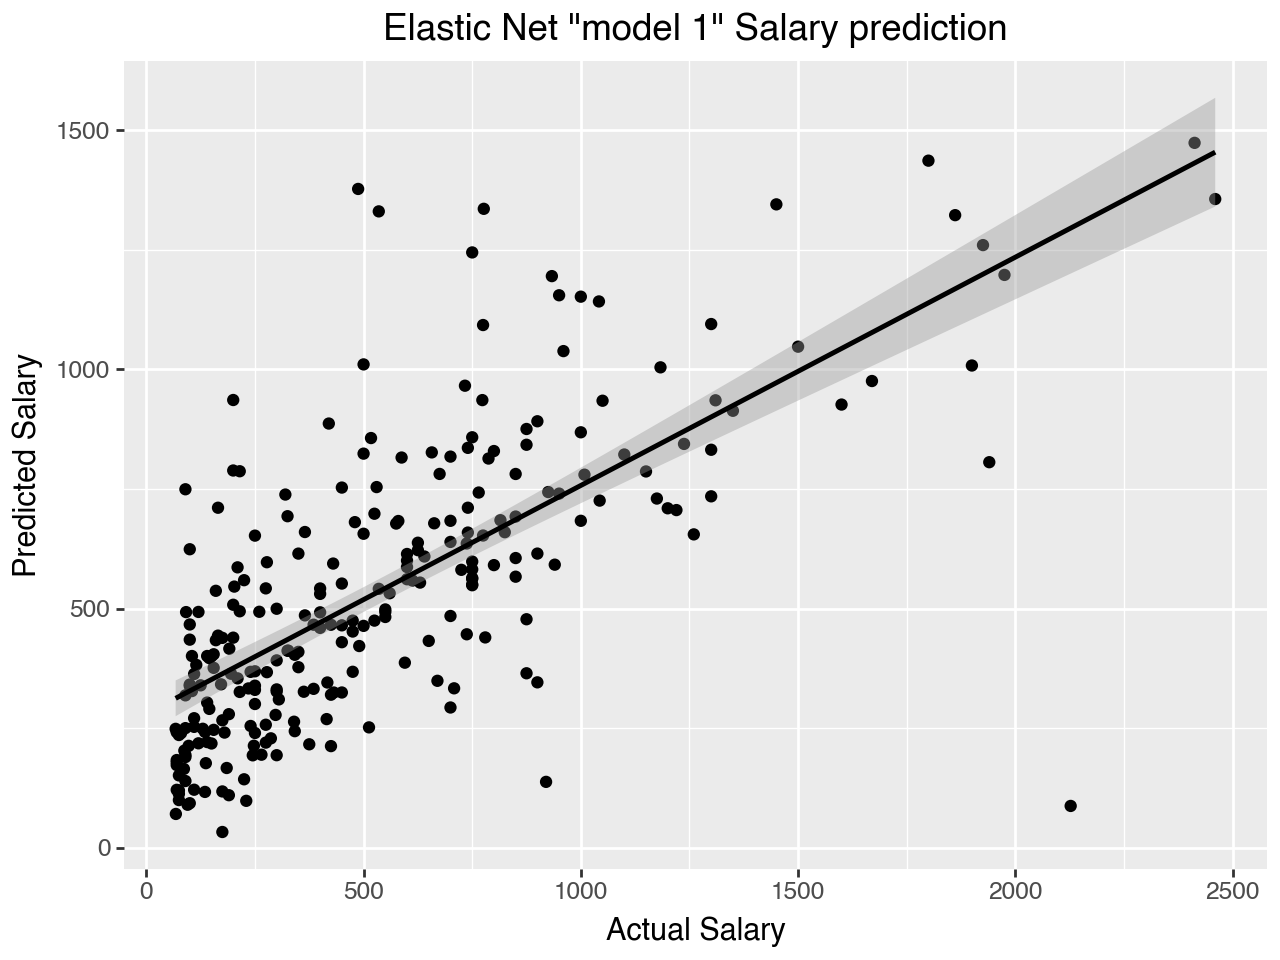

In [355]:
from plotnine import *
(ggplot(df_plt, aes(x = "Actual Salary", y = "Predicted Salary"))
+ geom_point()
+ geom_smooth(method = 'lm')
+ labs(title = 'Elastic Net "model 1" Salary prediction')
)

On the plot it's visible how the Elastic Net model prediction line fits the trend of the actual salary data, however it also under and overestimates compared to the actual data on both low and high ends of values.